In [1]:
import pvdeg
from global_land_mask import globe
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
import pandas as pd
import xarray as xr
import dask.array as da
import dask.dataframe as dd
from dask.distributed import LocalCluster, Client, Lock
import dask.delayed

In [2]:
# decrease the arange step size for more fine resolution
# increase the arange step size for increased granularity
lon_UK = np.arange(-10.5, 1.76, 1)
lat_UK = np.arange(49.95, 60, 2)
lon_grid_UK, lat_grid_UK = np.meshgrid(lon_UK,lat_UK)
land_UK = globe.is_land(lat_grid_UK, lon_grid_UK)

lon_land_UK = lon_grid_UK[land_UK]
lat_land_UK = lat_grid_UK[land_UK]

lon_Scan = np.arange(-10.5, 31.6, 0.3)
lat_Scan = np.arange(60, 71.2, 0.3)
lon_grid_Scan, lat_grid_Scan = np.meshgrid(lon_Scan,lat_Scan)
land_Scan = globe.is_land(lat_grid_Scan, lon_grid_Scan)

lon_land_Scan = lon_grid_Scan[land_Scan]
lat_land_Scan = lat_grid_Scan[land_Scan]

In [3]:
workers = 4

cluster = LocalCluster(
    n_workers=workers,
    processes=True, 
    )

client = Client(cluster)

print(client.dashboard_link)

http://127.0.0.1:8787/status


In [4]:
coords = list(zip(lat_land_UK, lon_land_UK)) # easiest way to make a list of the right shape

weather_ds, meta_df, failed_gids = pvdeg.weather.weather_distributed(database="PVGIS", coords=coords)

In [5]:
weather_ds.compute()

c:\Users\tford\AppData\Local\miniconda3\envs\deg\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 13.27 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.Dataset> Size: 14MB
Dimensions:            (gid: 22, time: 8760)
Coordinates:
  * time               (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T2...
  * gid                (gid) int32 88B 0 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 21
Data variables:
    temp_air           (gid, time) float64 2MB 4.11 4.7 5.28 ... 0.35 0.37 0.38
    relative_humidity  (gid, time) float64 2MB 87.27 87.03 86.79 ... 86.37 86.14
    ghi                (gid, time) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dni                (gid, time) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dhi                (gid, time) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    IR(h)              (gid, time) float64 2MB 314.4 317.4 320.4 ... 271.9 274.1
    wind_speed         (gid, time) float64 2MB 3.11 3.1 3.08 ... 3.53 3.45 3.37
    wind_direction     (gid, time) float64 2MB 269.0 274.0 279.0 ... 245.0 242.0
    pressure           (gid, time) float64 2MB 1.014e+05 1.014e+05 ... 9.965e+04

### Saving Geospatial Data Locally

The goal of `pvdeg.store` is to create a living local database of meteoroligical data that grows overtime as your geospatial data needs grow. To do this `PVDeg` will save to a folder called `PVDeg-Meteorological` your user home directory. For me this is located at `C:\Users\tford\PVDeg-Meteorological`. This directory will contain a `zarr` store, this is a popular format for storing multi-dimensional array data, not dissimilar to `h5` files. It was chosen over `h5` because `zarr` stores arrays in chunked compressed files that make access very easy without opening an entire file like `h5`. This is an oversimplification of the design process but we felt `zarr` was a better fit.

## Store

We can use `pvdeg.store.store` to save geospatial data to our living dataset in the common form provided by `pvdeg`. The data is stored in various groups and subfolders but they will be arranged based on the *source* and *periodicity*.

For example:  
    - Hourly PVGIS data will be saved to a group called "PVGIS-1hr"  
    - 30 minute PVGIS to a group called "PVGIS-30min"  
    - 15 minute PVGIS will be saved to a group called "PVGIS-15min"  

In [6]:
pvdeg.store.store(weather_ds, meta_df)

Creating Zarr


c:\Users\tford\AppData\Local\miniconda3\envs\deg\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 13.27 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


dataset saved to zarr store at C:\Users\tford\PVDeg-Meteorological


## Load

`PVDeg` makes use of `dask` to handle larger than memory datasets. Trandionally, this was only useful in our HPC environment but as your local database grows overtime, it will eventually surpass the limits of your computer's volatile memory. Additionally, `dask` allows us to parallelize geospatial calculations via `pvdeg.geospatial.analysis`. This ability can be utilized on local machines or HPC clusters alike.  

`PVDeg` implements the ability to access your local living database via `pvdeg.store.get`. This method takes a string called `group`. Groups are created automatically in your store when you save data using `pvdeg.store.store`. As described in the `pvdeg.store.store` docstring and the *Store* section above, NSRDB will follow a similar scheme but it not implemented yet.  
    - Hourly PVGIS data will be saved to a group called "PVGIS-1hr"  
    - 30 minute PVGIS to a group called "PVGIS-30min"  
    - 15 minute PVGIS will be saved to a group called "PVGIS-15min"  

### Load PVGIS-1hr Data

The example below shows us loading the hourly tmy data from PVGIS that we gathered and saved to our zarr store in the above cells. This gets us the form of a weather xarray.Dataset (`geo_weather` in this example) and a metadata dataframe (`geo_meta` in this example).

These can be treated like any other geospatial data shown in the `pvdeg` tutorials and tools or documentation.

In [7]:
geo_weather, geo_meta = pvdeg.store.get(group="PVGIS-1hr")

### Inspecting the Results

explain *.compute() and dask here*

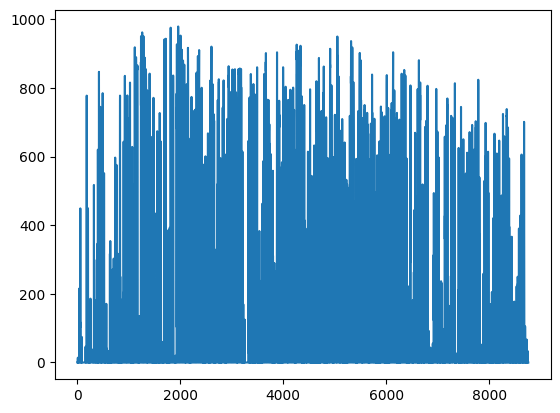

In [8]:
import matplotlib.pyplot as plt

plt.plot(geo_weather.sel(gid=0).dni)

In [9]:
geo_meta

,latitude,longitude,altitude,Source,wind_height
gid,,,,,
0,49.95,1.5,176.0,PVGIS,10
1,51.95,-9.5,330.0,PVGIS,10
2,51.95,-8.5,137.0,PVGIS,10
3,51.95,-4.5,184.0,PVGIS,10
4,51.95,-3.5,160.0,PVGIS,10
5,51.95,-2.5,86.0,PVGIS,10
6,51.95,-1.5,217.0,PVGIS,10
7,51.95,-0.5,94.0,PVGIS,10
8,51.95,0.5,64.0,PVGIS,10


## Geospatial Calculations from Locally Stored Data

As shown above we can load from our `zarr` store and treat it like any other geospatial data in `pvdeg`.

For demonstration we can run the analysis below to estimate effective standoff height and operating temperatures for the provided data. It may look like the `geo_res` contains empty results but that is because we did not have input data for all of the points in the input grid (think of this as a 2D plane formed between the latitude and longitude axes). Clicking on the stack of three circles in the bottom cell will expand the datavariable (like an attribute of the multidimensional array structure) and show the results.

Additionally, we can interpolate and plot the results.

In [10]:
func=pvdeg.standards.standoff

template = pvdeg.geospatial.auto_template(
    func=func,
    ds_gids=geo_weather
)

geo_res = pvdeg.geospatial.analysis(
    weather_ds=geo_weather,
    meta_df=geo_meta,
    func=func,
    template=template
)

In [ ]:
geo_res

This plot lacks information on the area and does not include some political boundary lines. For more information on plotting look at the `Scenario - Non-uniform Mountain Downselect.ipynb` tutorial in the tutorials and tools folder.

In [ ]:
pvdeg.geospatial.plot_sparse_analysis_land(geo_res, data_var='T98_0', method="nearest", resolution=10j)

### Growing Our Living Store

What if we want to download more points from Europe? We can keep our old download in the store and shelve it to look at northern Europe.

We will start by generating a range of points that cover Europe.

In [10]:
lon_EU = np.arange(-25.0, 51.0, 1)  # Adjusted for EU longitudes
lat_EU = np.arange(34.0, 73.0, 2)    # Adjusted for EU latitudes

# Create meshgrid for EU
lon_grid_EU, lat_grid_EU = np.meshgrid(lon_EU, lat_EU)

# Check land coverage in the EU
land_EU = globe.is_land(lat_grid_EU, lon_grid_EU)

# Extract land coordinates in the EU
lon_land_EU = lon_grid_EU[land_EU]
lat_land_EU = lat_grid_EU[land_EU]

# Define the Scan grid ranges
lon_Scan = np.arange(-10.5, 31.6, 0.3)
lat_Scan = np.arange(60, 71.2, 0.3)
lon_grid_Scan, lat_grid_Scan = np.meshgrid(lon_Scan, lat_Scan)
land_Scan = globe.is_land(lat_grid_Scan, lon_grid_Scan)

lon_land_Scan = lon_grid_Scan[land_Scan]
lat_land_Scan = lat_grid_Scan[land_Scan]

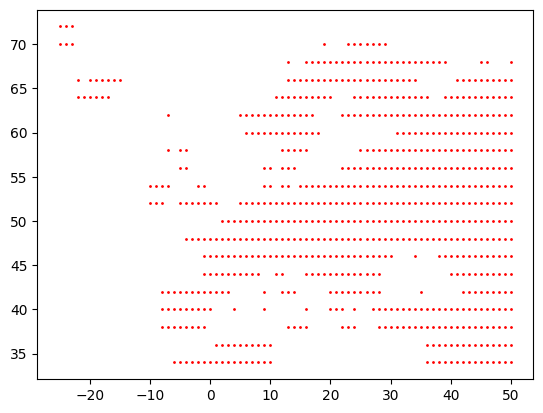

In [11]:
plt.scatter(lon_land_EU, lat_land_EU, c='r', s=1)

In [12]:
w, m, failed_gids = pvdeg.weather.weather_distributed(database="PVGIS", coords=[(lat_land_EU[0], lon_land_EU[0])])

In [13]:
pvdeg.store.store(weather_ds=w, meta_df=m)

adding to store
opening store
add entry to dataset
dataset saved to zarr store at C:\Users\tford\PVDeg-Meteorological


In [14]:
loaded_weather, loaded_meta = pvdeg.store.get(group="PVGIS-1hr")

In [15]:
loaded_meta

,latitude,longitude,altitude,Source,wind_height
gid,,,,,
0,49.95,1.5,176.0,PVGIS,10
1,51.95,-9.5,330.0,PVGIS,10
2,51.95,-8.5,137.0,PVGIS,10
3,51.95,-4.5,184.0,PVGIS,10
4,51.95,-3.5,160.0,PVGIS,10
5,51.95,-2.5,86.0,PVGIS,10
6,51.95,-1.5,217.0,PVGIS,10
7,51.95,-0.5,94.0,PVGIS,10
8,51.95,0.5,64.0,PVGIS,10


In [16]:
loaded_weather

<xarray.Dataset> Size: 15MB
Dimensions:            (gid: 23, time: 8760)
Coordinates:
  * gid                (gid) int32 92B 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22
  * time               (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T2...
Data variables:
    IR(h)              (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    dhi                (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    dni                (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    ghi                (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    pressure           (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    relative_humidity  (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    temp_air           (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    wind_direction     (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    wind_speed         (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>

In [17]:
loaded_weather.sel(gid=22).compute()

<xarray.Dataset> Size: 701kB
Dimensions:            (time: 8760)
Coordinates:
    gid                int32 4B 22
  * time               (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T2...
Data variables:
    IR(h)              (time) float64 70kB 290.6 286.7 282.9 ... 298.3 294.4
    dhi                (time) float64 70kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dni                (time) float64 70kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ghi                (time) float64 70kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pressure           (time) float64 70kB 9.939e+04 9.939e+04 ... 9.868e+04
    relative_humidity  (time) float64 70kB 81.69 82.97 84.25 ... 79.12 80.4
    temp_air           (time) float64 70kB 8.03 7.1 6.17 5.23 ... 10.84 9.9 8.97
    wind_direction     (time) float64 70kB 165.0 164.0 163.0 ... 239.0 238.0
    wind_speed         (time) float64 70kB 3.02 2.75 2.47 2.2 ... 3.84 3.57 3.3

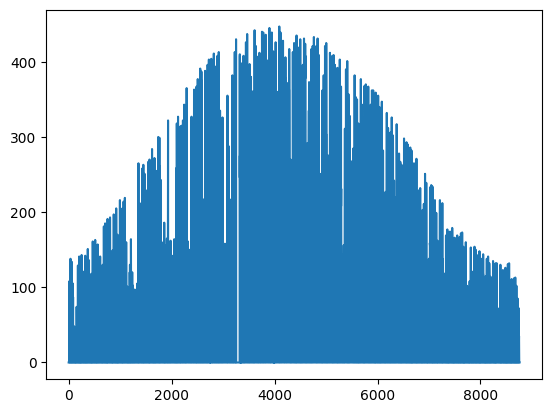

In [18]:
import matplotlib.pyplot as plt

plt.plot(loaded_weather.sel(gid=0).dhi)

In [19]:
wet, met = pvdeg.store.get("PVGIS-1hr")

In [20]:
wet

<xarray.Dataset> Size: 15MB
Dimensions:            (gid: 23, time: 8760)
Coordinates:
  * gid                (gid) int32 92B 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22
  * time               (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T2...
Data variables:
    IR(h)              (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    dhi                (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    dni                (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    ghi                (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    pressure           (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    relative_humidity  (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    temp_air           (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    wind_direction     (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>
    wind_speed         (gid, time) float64 2MB dask.array<chunksize=(22, 8760), meta=np.ndarray>

In [21]:
loaded_meta

,latitude,longitude,altitude,Source,wind_height
gid,,,,,
0,49.95,1.5,176.0,PVGIS,10
1,51.95,-9.5,330.0,PVGIS,10
2,51.95,-8.5,137.0,PVGIS,10
3,51.95,-4.5,184.0,PVGIS,10
4,51.95,-3.5,160.0,PVGIS,10
5,51.95,-2.5,86.0,PVGIS,10
6,51.95,-1.5,217.0,PVGIS,10
7,51.95,-0.5,94.0,PVGIS,10
8,51.95,0.5,64.0,PVGIS,10


In [26]:
func=pvdeg.standards.standoff

template = pvdeg.geospatial.auto_template(
    func=func,
    ds_gids=loaded_weather
)

loaded_geo_res = pvdeg.geospatial.analysis(
    weather_ds=loaded_weather,
    meta_df=loaded_meta,
    func=func,
    template=template
)

(<Figure size 1000x800 with 2 Axes>, <GeoAxes: >)

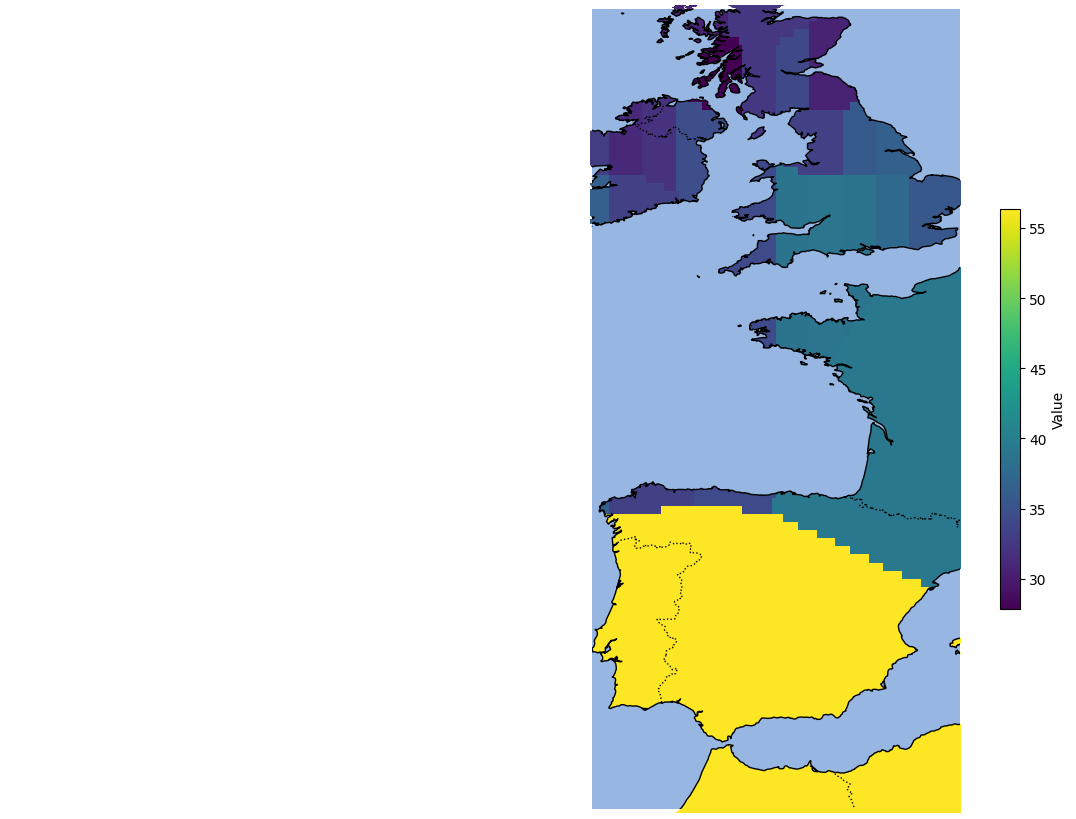

In [27]:
pvdeg.geospatial.plot_sparse_analysis_land(loaded_geo_res, data_var="T98_inf")